In [74]:
import numpy as np
import matplotlib.pyplot as plt


In [75]:
import random
from sklearn.neighbors import NearestNeighbors
import numpy as np
class Smote:
    def __init__(self,samples,N=10,k=5):
        self.n_samples,self.n_attrs=samples.shape
        self.N=N
        self.k=k
        self.samples=samples
        self.newindex=0

    def over_sampling(self):
        N=int(self.N)
        self.synthetic = np.zeros((self.n_samples * N, self.n_attrs))
        neighbors=NearestNeighbors(n_neighbors=self.k).fit(self.samples)  
        for i in range(len(self.samples)):
#             print('samples',self.samples[i])
            nnarray=neighbors.kneighbors(self.samples[i].reshape((1,-1)),return_distance=False)[0]  #Finds the K-neighbors of a point.
#             print ('nna',nnarray)
            self._populate(N,i,nnarray)
        return self.synthetic


    # for each minority class sample i ,choose N of the k nearest neighbors and generate N synthetic samples.
    def _populate(self,N,i,nnarray):
        for j in range(N):
            nn=random.randint(0,self.k-1)
            dif=self.samples[nnarray[nn]]-self.samples[i]
            gap=random.random()
            self.synthetic[self.newindex]=self.samples[i]+gap*dif
            self.newindex+=1
#             print(self.synthetic)
            
# a=np.array([[1,2,3],[4,5,6],[2,3,1],[2,1,2],[2,3,4],[2,3,4]])
# s=Smote(a,N=2)
# n= s.over_sampling()
# print(np.shape(n))

In [76]:

def save_balanced_data( train_i,train_t,test_i,test_t,train_name="balanced_train",test_name="test"):
    
    fp = open('./Balanced-data/'+train_name+'.txt','w+')
    for i in range(len(train_i)):
        d_str = str(train_t[i]) + '\t' +str(train_i[i,:].tolist())[1:-1].replace(',','') +'\n'
        fp.write(d_str)
    fp.close()
    
    fp = open('./Balanced-data/'+test_name+'.txt', 'w+')
    for i in range(len(test_i)):
        d_str = str(test_t[i]) + '\t' + str(test_i[i, :].tolist())[1:-1].replace(',','') + '\n'
        fp.write(d_str)
    fp.close()

    pass


def balance_data(aep_i,aep_t, non_aep_i,non_aep_t,pattern_N= 450,method ='undersampling', test_aep_ratio= 0.3,test_nonaep_ratio= 0.3):
    """

    :param aep_i:
    :param aep_t:
    :param non_aep_i:
    :param non_aep_t:
    :param pattern_N: the number of training input of each pattern
    :param method:
    :param test_aep_ratio:
    :param test_nonaep_ratio:
    :return:
    """

    print("Original data size:")
    print("aep:",len(aep_i),'non_aep:',len(non_aep_i))
    # split test set and train set
    test_aep_sample = int(test_aep_ratio*len(aep_i))
    aep_test_i = aep_i[0:test_aep_sample,:]
    aep_test_t = aep_t[0:test_aep_sample]
    
    test_nonaep_sample = int(test_nonaep_ratio*len(non_aep_i))
    non_aep_test_i = non_aep_i[0:test_nonaep_sample,:]
    non_aep_test_t = non_aep_t[0:test_nonaep_sample]

    # test set
    test_i = np.concatenate((aep_test_i,non_aep_test_i),axis=0)
    test_t = []
    test_t.extend(aep_test_t)
    test_t.extend( non_aep_test_t)

    # train set
    aep_i =aep_i[test_aep_sample:,:]
    aep_t = np.array(aep_t[test_aep_sample:])
    non_aep_i = non_aep_i[test_nonaep_sample:, :]
    non_aep_t = non_aep_t[test_nonaep_sample:]

 
    # balance training set here
    if method == 'oversampling':
        print("Using oversampling...")
        sample_range = len(aep_i)
        indices = np.random.randint(sample_range, size=len(non_aep_i))
        new_aep_i = aep_i[indices,:]
        new_aep_t = aep_t[indices]
        
        train_i = np.concatenate((new_aep_i, non_aep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(non_aep_t)


    elif method == 'undersampling':
        print("Using undersampling...")
        sample_range = len(non_aep_i)
        indices = np.random.randint(sample_range, size=len(aep_i))
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        
        train_i = np.concatenate((aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(aep_t)
        train_t.extend(new_nonaep_t)
        pass
    elif method == 'SMOTE':
        print("Using SMOTE...")
        #generate new aep data
        s= Smote(aep_i,N=10*len(aep_i))
        new_aep_i = s.over_sampling()
        indices = np.random.randint(len(new_aep_i), size=pattern_N)
        new_aep_i = new_aep_i[indices,:]
        new_aep_t = [1.0]*len(new_aep_i)
        
        #downsample non aep data and make aep and non_aep data have same size 
        indices = np.random.randint(len(non_aep_i), size=len(new_aep_i))
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        #first half of data is aep, second half of data is non_aep
        train_i = np.concatenate((new_aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(new_nonaep_t)
        
    else:
        print("Using undersampling+ oversampling...")
        #Default downsample non_aep data and oversample aep data randomly
        #downsample non_aep data
        sample_size = pattern_N
        indices = np.random.randint(len(non_aep_i), size=sample_size)
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        #oversample aep data
        indices = np.random.randint(len(aep_i), size=sample_size)
        new_aep_i = aep_i[indices,:]
        new_aep_t = aep_t[indices]
        
        train_i = np.concatenate((new_aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(new_nonaep_t)
        pass


    return train_i,train_t,test_i,test_t



def load_balanced_data(train_name="balanced_train",test_name="test"):
   
    train_i = []
    train_t = []
    test_i = []
    test_t = []
    fp = open('./Balanced-data/'+train_name+'.txt','r')
    lines= fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        target, inputs =line.split('\t')[0],line.split('\t')[1]
        data = [float(s) for s in inputs.split(' ') if s != '']
        train_t.append(float(target))
        train_i.append(data)
    fp.close()
    
    fp = open('./Balanced-data/'+test_name+'.txt','r')
    lines= fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        target, inputs =line.split('\t')[0],line.split('\t')[1]
        data = [float(s) for s in inputs.split(' ') if s != '']
        test_t.append(float(target))
        test_i.append(data)
    fp.close()
    
    train_i, train_t, test_i, test_t = np.array(train_i),np.array(train_t),np.array(test_i),np.array(test_t)
    
    return train_i, train_t, test_i, test_t



def create_balanced_data(method="SMOTE"):
    fp = open('db4_Diff1f_100_128w_AEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    aep_i = []
    aep_t = []
    non_aep_i = []
    non_aep_t = []

    for line in lines:
        line = line.split('\n')[0]
        data = [float(s) for s in line.split(' ') if s != '']
        aep_i.append(data)
        aep_t.append(1)
    fp.close()

    aep_i = np.array(aep_i)
    aep_t = np.array(aep_t)

    fp = open('db4_Diff1f_100_128w_nonAEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        data = [float(s) for s in line.split(' ') if s != '']
        non_aep_i.append(data)
        non_aep_t.append(0)
    fp.close()
    non_aep_i = np.array(non_aep_i)
    non_aep_t = np.array(non_aep_t)

    
    
    train_i, train_t, test_i, test_t= balance_data(aep_i,aep_t,non_aep_i,non_aep_t,method=method)
    
    train_i, train_t, test_i, test_t = np.array(train_i),np.array(train_t),np.array(test_i),np.array(test_t)
    return train_i, train_t, test_i, test_t


In [77]:
class MLFF():
    def __init__(self,input_shape = 27, bias=False):
#         np.random.seed(1)
        self.weights = {}
        self.bias_enabled = bias
        self.weight_correction = {}
        self.delta ={}
        self.input_shape = input_shape
        self.num_layer = 1 # initialize input layer
        self.func_pair = {'logistic':(self.logistic,self.d_logistic),'relu':(self.relu,self.d_relu),'tanh':(self.tanh,self.d_tanh)}
        self.activate = {}
        self.derivative = {}
        
    def add_layer(self,shape, activation=None,initializer='random'):
        if initializer =='zero':
            # zero initializer
            self.weights[self.num_layer] = np.vstack((np.zeros(shape[1]), np.zeros((shape))))
        else:
            #random initializer
            # The first row is bias 
            self.weights[self.num_layer] = np.vstack((10*np.random.random(shape[1])-5, 10*np.random.random(shape)-5))
        self.weight_correction[self.num_layer]= np.zeros((shape[0]+1, shape[1]))
        
        self.num_layer += 1
        
        # the address to activation function
        if activation is not None and activation is not '':
            self.activate[self.num_layer] = self.func_pair[activation][0]
            self.derivative[self.num_layer] = self.func_pair[activation][1]
        else:
            self.activate[self.num_layer] = self.logistic
            self.derivative[self.num_layer] = self.d_logistic
            
        
    def logistic(self, net):
        k = 0.01
        return 1/(1+ np.exp(-k*net))
    
    def d_logistic(self,net,out):
        """
        out: numpy array
        """
        k = 0.01
        return k*out*(1.0- out)

    
    def tanh(self,net):
        return np.tanh(net)
    
    def d_tanh(self,net,o):
        return 1.0-np.square(o)
    
    def relu(self,net):
        k =1.0
        k1= 0.1
        ma = k*np.maximum(net, np.zeros(np.shape(net)))
        mi = k1*np.minimum(net, np.zeros(np.shape(net)))
        return ma+mi
    
    def d_relu(self, net,o):
        k = 1.0
        k1 = 0.1
        z = np.zeros(np.shape(net))
        m = np.maximum(z,net)
        deriv = np.where(m>0.0,k,m)
        deriv = np.where(deriv==0.0,k1,deriv)
        return deriv
    
    
    def feedforward(self,inputs,bias= False):
        """
        input: 1-D array
        """
        out = {}
        out[1] = inputs
        for i in range(self.num_layer-1):
            layer = i+1
            net = np.dot(out[layer], self.weights[layer][1:,:])
            if bias:
                net += self.weights[layer][0,:]
            out[layer+1]= self.activate[layer+1](net)
            
        return out, out[self.num_layer]
    
        
    def backforward(self,out, target,alpha,momentum_coeff, bias = False,momentum_enabled=False):
        """
        Apply General delta rule to backforward
        out: the dictionary storing all outputs in different layers
        """
        pred = out[self.num_layer]
        dE_o = -(target- pred)
        prev_net = np.dot(out[self.num_layer-1], self.weights[self.num_layer-1][1:,:])
        if bias:
            prev_net += self.weights[self.num_layer-1][0,:]
        
        
        
        self.delta[self.num_layer] = -np.multiply(dE_o, self.derivative[self.num_layer](prev_net,pred) )
        # calculate delta of each layer
        # calculate delta from layer-2 to the last second layer,since the input layer doesn't have delta
        # delta  of the output layer is determined by output
        for layer in reversed(range(2, self.num_layer)):
            last_delta = self.delta[layer+1] 
            
            dE_o =np.dot(self.weights[layer][1:,:], last_delta)
            prev_net = np.dot(out[layer-1], self.weights[layer-1][1:,:])
            if bias:
                prev_net += self.weights[layer-1][0,:]
                
            d_f =self.derivative[layer](prev_net,out[layer])
            self.delta[layer] = -np.multiply(dE_o, d_f)

        #calculate weight correction
        for layer in range(1, self.num_layer):
            if not momentum_enabled:
                momentum_coeff = 1.0
            delta_p = np.multiply(self.delta[layer+1],np.reshape(out[layer], (len(out[layer]), 1)))
            self.weight_correction[layer][1:,:] = alpha*delta_p + momentum_coeff* self.weight_correction[layer][1:,:]
            #update bias if enabled
            if bias:
                self.weight_correction[layer][0,:] = alpha*self.delta[layer+1] 
                + momentum_coeff*self.weight_correction[layer][0,:]
            
        return None
    
    
    def predict(self, inputs,bias=False):
        _, preds = self.feedforward(inputs,bias)
        preds = np.array([1 if p>=0.5 else 0 for p in preds])
        return preds
    
#     def gradient_descent(self,alpha,beta,momentum= None):
        
#         new_momentum= self.weight_correction.copy()
# #         print("old wc:",self.weight_correction)
#         for layer in range(1, self.num_layer):
#             if momentum is not None:
# #                 print("mm:",beta* momentum[layer])
#                 self.weight_correction[layer] = alpha*self.weight_correction[layer] + beta* momentum[layer]
# #                 print("Update weigth with momentum")
            
#             else:
# #                 print("Without momentum")
#                 self.weight_correction[layer] = alpha*self.weight_correction[layer]
#             self.weights[layer] += self.weight_correction[layer]
#             #update momentum
#             new_momentum[layer] = self.weight_correction[layer]
# #         print("new wc:",self.weight_correction)
        
#         for layer in range(1, self.num_layer):   
#             #reset weight correction after updating weights
#             self.weight_correction[layer]= np.zeros(np.shape(self.weight_correction[layer]))
        
#         return new_momentum
        
    
    def gradient_descent(self):
        for layer in range(1, self.num_layer):
            self.weights[layer] += self.weight_correction[layer]
            #reset weight correction after updating weights
            self.weight_correction[layer]= np.zeros(np.shape(self.weight_correction[layer]))

        return None
    
    def train(self,inputs,targets,adaptive_rate=True,alpha0=0.9, beta0=0.5,
              bias =False,momentum_enabled = False,max_iteration = 1000,interval =100):
        pre_err= 0.0
        sens = 0.0
        spec =0.0
        e_th = 50.0
        threshold = 1e-3
        momentum  = None
        Etss = []
        sensitivity = []
        specificity = []
        
        alpha = alpha0
        
        for epoch in range(max_iteration):
            err = 0.0
            #need to decrease learning rate alpha, otherwise, it would not decrease error, error doesn't converge
            if adaptive_rate:
                    alpha = alpha0/(0.001*epoch+1.0)
                
            
            beta = beta0

            for i in range(len(inputs)):
                outs, pred= self.feedforward(inputs[i,:],bias)
                
                err  += 0.5*pow(targets[i]-pred[0], 2)
                self.backforward(outs,targets[i],alpha=alpha,
                                 momentum_coeff=beta,
                                 bias=bias,
                                 momentum_enabled =momentum_enabled)
        
            
            #trained by epoch
            m = self.gradient_descent()

            #save data every 10 epochs
            if epoch % 100 == 0:
                preds = self.predict(inputs,bias)
                eap_cnts = float(np.sum(targets))
                TP = np.sum(preds[np.where(targets == 1)])
                sens = TP/eap_cnts
                
                noneap_cnts =float(len(targets) - float(np.sum(targets))) 
                TN = len(preds[np.where(targets == 0)])- np.sum(preds[np.where(targets == 0)])
                spec = TN/noneap_cnts
                sensitivity.append(sens)
                
                specificity.append(spec)
                Etss.append(err)
                #print data after every interval epochs pass
                if  epoch%interval == 0:  
                    print("Epoch:", epoch,"Error:",err,"Sensitivity:",sens,"specificity:",spec)
            
            
            if epoch>1 and ( err<=e_th ):
                break
                pass
            
            else:
                pre_err = err
            
        return Etss, specificity, sensitivity
            

In [224]:
## generate and save balanced data here
# train_i, train_t, test_i, test_t = create_balanced_data(method="undersampling")
# save_balanced_data(train_i, train_t, test_i, test_t,train_name="under_sampling_train",test_name="under_sampling_test")
# print("shape:",np.shape(train_i),np.shape(train_t),np.shape(test_i))

train_i, train_t, test_i, test_t = create_balanced_data(method="SMOTE")
save_balanced_data(train_i, train_t, test_i, test_t,train_name="SMOTE_train_v1",test_name="SMOTE_test_v1")



Original data size:
aep: 83 non_aep: 2482
Using SMOTE...


In [78]:
# load balanced data and shuffle them
# train_i, train_t, test_i, test_t = load_balanced_data(train_name="under_sampling_train",test_name="under_sampling_test")
train_i, train_t, test_i, test_t = load_balanced_data(train_name="SMOTE_train_v1",test_name="SMOTE_test_v1")

print("shape:",np.shape(train_i),np.shape(train_t),np.shape(test_i),np.shape(test_t))
# print((train_t[0:500]),(train_t[500:]))

from sklearn.utils import shuffle
train_i, train_t = shuffle(train_i, train_t)




shape: (900, 27) (900,) (768, 27) (768,)


In [79]:
#normalize data
len_train = len(train_i)
len_test = len(test_i)
data = np.concatenate([train_i,test_i])
#normalize data to range [-1,1]
new_max =1.0
new_min = 0.0
norm_data = ((data- np.min(data,axis=0))/(np.max(data,axis=0) - np.min(data,axis=0)))*(new_max-new_min)+new_min
norm_train_i = norm_data[0:len_train,:]
test_i = norm_data[len_train:,:]
np.shape(norm_data), np.shape(data), np.shape(norm_train_i), np.shape(test_i)

((1668, 27), (1668, 27), (900, 27), (768, 27))

In [80]:
# save weights
def save_weights(w,i):
    import json
    fp = open("weights/model_case_"+str(i)+".txt","w+")
    fp.write(json.dumps(w))
    fp.close()

def load_weights(model,surfix='',layer=3):
    import json
    i =1 if model =='model_1' else 2
    fp = open("weights/model_case_"+surfix+".txt","r")
    line= fp.read()
    w= json.loads(line)
    d={}
    for i in range(layer):
        l= i+1
        d[l]=np.array(w[str(l)])
    
    return d

def save_curves(case,name,epoch,err, sens,specif):
    import json
    fp = open("Case-"+str(case)+"-data"+"/log_"+name+".txt","w+")
    for i in range(len(epoch)):
        fp.write(str(epoch[i])+" "+str(err[i])+" "+str(sens[i])+" "+str(specif[i])+"\n")
           
    fp.close()

In [108]:
#initialize weights of case 1 randomly
# if using relu, max iteration =1000,  learning rate <=0.003
# if learning rate is big, error is easy to rise up again

d = 27
model_1 = MLFF(input_shape  = d)
model_1.add_layer((d,d),activation='relu')
model_1.add_layer((d,2*d+1),activation='relu')
model_1.add_layer((2*d+1,d),activation='relu')
model_1.add_layer((d,1),activation='')
#backup weights of case 1
# model_1_weights = model_1.weights.copy()
d1= {}
for k in model_1.weights.keys():
    d1[k]=model_1.weights[k].tolist()
save_weights( d1,"new_arch")

In [ ]:
#case 1: determine learning rate
model_1.weights=load_weights("model_1",surfix="new_arch",layer=len(model_1.weights.keys()))
Etss_1a, specif_1a, sens_1a = model_1.train(norm_train_i,train_t,adaptive_rate = False,alpha0= 0.01,
                                   bias=False,momentum_enabled=False ,max_iteration = 1000)


Epoch: 0 Error: 224.99999999999778 Sensitivity: 1.0 specificity: 0.0
Epoch: 100 Error: 224.99999999999778 Sensitivity: 1.0 specificity: 0.0
Epoch: 200 Error: 224.99999999999778 Sensitivity: 1.0 specificity: 0.0
Epoch: 300 Error: 224.99999999999778 Sensitivity: 1.0 specificity: 0.0


In [ ]:

epochs = [i*100 for i in range(len(Etss_1a))]
save_curves(1,"rate_0.001",epochs,Etss_1a, specif_1a, sens_1a )
#save weights
d1= {1:model_1.weights[1].tolist(),2:model_1.weights[2].tolist()}
save_weights( d1,"1_a")

In [252]:

preds = model_1.predict(test_i,bias=False)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 1 acc:",acc)


Model 1 acc: 0.83203125


In [13]:
#case 1: determine learning rate

model_1.weights=load_weights("model_1")
Etss_1b, specif_1b, sens_1b = model_1.train(norm_train_i,train_t,adaptive_rate = False,alpha0= 0.003,
                                   bias=False,momentum_enabled=False ,max_iteration = 4000,interval=100)

save_curves(1,"rate_0.003",epochs,Etss_1b, specif_1b, sens_1b )
#save weights
d1= {1:model_1.weights[1].tolist(),2:model_1.weights[2].tolist()}
save_weights( d1,"1_b")

Epoch: 0 Error: 128.6129211442303 Sensitivity: 0.0 specificity: 0.995
Epoch: 100 Error: 119.78456248152408 Sensitivity: 0.0 specificity: 0.9875
Epoch: 200 Error: 105.4687249510452 Sensitivity: 0.115 specificity: 0.7575
Epoch: 300 Error: 104.59508716732734 Sensitivity: 0.4625 specificity: 0.5225
Epoch: 400 Error: 105.07938787714538 Sensitivity: 0.495 specificity: 0.495
Epoch: 500 Error: 105.36098020474162 Sensitivity: 0.5225 specificity: 0.475
Epoch: 600 Error: 105.41307559577763 Sensitivity: 0.5 specificity: 0.49
Epoch: 700 Error: 105.33207084245788 Sensitivity: 0.5025 specificity: 0.4925
Epoch: 800 Error: 105.20421805038832 Sensitivity: 0.5125 specificity: 0.4975
Epoch: 900 Error: 105.02606466832347 Sensitivity: 0.5175 specificity: 0.495
Epoch: 1000 Error: 104.80239158400833 Sensitivity: 0.52 specificity: 0.485
Epoch: 1100 Error: 104.61526530933153 Sensitivity: 0.53 specificity: 0.4825
Epoch: 1200 Error: 104.46907117812042 Sensitivity: 0.5575 specificity: 0.475
Epoch: 1300 Error: 104.

In [14]:
preds = model_1.predict(test_i,bias=False)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 1 acc:",acc)
# print(Etss_1b, specif_1b, sens_1b )

Model 1 acc: 0.7122395833333334


In [172]:
#case 1: determine learning rate

model_1.weights=load_weights("model_1")
Etss_1c, specif_1c, sens_1c = model_1.train(norm_train_i,train_t,adaptive_rate = True,alpha0= 0.005,
                                   bias=False,momentum_enabled=False ,max_iteration = 3000)
save_curves(1,"adaptive_rate_0.01",epochs,Etss_1c, specif_1c, sens_1c )
#save weights
d1= {1:model_1.weights[1].tolist(),2:model_1.weights[2].tolist()}
save_weights( d1,"1_c")

Epoch: 0 Error: 122.83343214861941 Sensitivity: 1.0 specificity: 0.0
Epoch: 100 Error: 114.52807237746129 Sensitivity: 0.6622222222222223 specificity: 0.25333333333333335
Epoch: 200 Error: 114.57229786290539 Sensitivity: 0.4622222222222222 specificity: 0.4
Epoch: 300 Error: 114.82594445828512 Sensitivity: 0.44222222222222224 specificity: 0.40444444444444444
Epoch: 400 Error: 115.1582730323674 Sensitivity: 0.46 specificity: 0.4088888888888889
Epoch: 500 Error: 115.46945713021485 Sensitivity: 0.44222222222222224 specificity: 0.42
Epoch: 600 Error: 115.41502570773275 Sensitivity: 0.45555555555555555 specificity: 0.4266666666666667
Epoch: 700 Error: 115.15938915001617 Sensitivity: 0.46 specificity: 0.43777777777777777
Epoch: 800 Error: 114.94788368336422 Sensitivity: 0.47555555555555556 specificity: 0.4266666666666667
Epoch: 900 Error: 114.67901428301954 Sensitivity: 0.48444444444444446 specificity: 0.44666666666666666
Epoch: 1000 Error: 114.36337558371056 Sensitivity: 0.49777777777777776 

IndexError: list index out of range

In [173]:
preds = model_1.predict(test_i,bias=False)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 1 acc:",acc)


Model 1 acc: 0.609375


In [17]:
#case 1: determine learning rate
model_1.weights=load_weights("model_1")
Etss_1d, specif_1d, sens_1d = model_1.train(norm_train_i,train_t,adaptive_rate = False,alpha0= 0.01,
                                   bias=False,momentum_enabled=False ,max_iteration = 4000)
save_curves(1,"rate_0.01",epochs,Etss_1d, specif_1d, sens_1d )
#save weights
d1= {1:model_1.weights[1].tolist(),2:model_1.weights[2].tolist()}
save_weights( d1,"1_d")

Epoch: 0 Error: 128.6129211442303 Sensitivity: 0.0 specificity: 0.995
Epoch: 100 Error: 104.82618996423636 Sensitivity: 0.4875 specificity: 0.5075
Epoch: 200 Error: 105.40868004643447 Sensitivity: 0.5025 specificity: 0.4975
Epoch: 300 Error: 104.85440205139409 Sensitivity: 0.5225 specificity: 0.485
Epoch: 400 Error: 104.19553346673496 Sensitivity: 0.5625 specificity: 0.4775
Epoch: 500 Error: 102.86677749430798 Sensitivity: 0.605 specificity: 0.4975
Epoch: 600 Error: 101.44312786679104 Sensitivity: 0.575 specificity: 0.5375
Epoch: 700 Error: 99.96975847964639 Sensitivity: 0.565 specificity: 0.5625
Epoch: 800 Error: 98.63869311344058 Sensitivity: 0.5475 specificity: 0.5775
Epoch: 900 Error: 97.49216481314802 Sensitivity: 0.5525 specificity: 0.59
Epoch: 1000 Error: 96.59738235186703 Sensitivity: 0.55 specificity: 0.6
Epoch: 1100 Error: 96.0788979314691 Sensitivity: 0.53 specificity: 0.61
Epoch: 1200 Error: 95.56384858726909 Sensitivity: 0.52 specificity: 0.625
Epoch: 1300 Error: 95.204831

In [18]:
# epochs = [i*100 for i in range(len(Etss_1a))]
# save_curves(1,"rate_0.001",epochs,Etss_1a, specif_1a, sens_1a )
# save_curves(1,"rate_0.003",epochs,Etss_1b, specif_1b, sens_1b )
# save_curves(1,"rate_0.01",epochs,Etss_1d, specif_1d, sens_1d )
# save_curves(1,"adaptive_rate_0.01",epochs,Etss_1c, specif_1c, sens_1c )


In [19]:
#case 3 uses the weights from case 1
model_3 = MLFF(input_shape  = d)
model_3.add_layer((d,2*d+1),activation='relu')
model_3.add_layer((2*d+1,1),initializer='')



In [20]:
model_3.weights=load_weights("model_1")
Etss_3a, specif_3a, sens_3a = model_3.train(norm_train_i,train_t,adaptive_rate = True,alpha0= 0.01,
                                            beta0=0.99,bias=False,momentum_enabled=True ,max_iteration = 4000)

Epoch: 0 Error: 128.6129211442303 Sensitivity: 0.0 specificity: 0.995
Epoch: 100 Error: 128.06761329003555 Sensitivity: 0.0 specificity: 0.995
Epoch: 200 Error: 124.70430118280125 Sensitivity: 0.0 specificity: 0.9925
Epoch: 300 Error: 120.07676208252761 Sensitivity: 0.0 specificity: 0.9875
Epoch: 400 Error: 114.92657989994665 Sensitivity: 0.0 specificity: 0.985
Epoch: 500 Error: 110.57007527635834 Sensitivity: 0.0 specificity: 0.9525
Epoch: 600 Error: 106.95424686713925 Sensitivity: 0.0125 specificity: 0.8675
Epoch: 700 Error: 105.33554689018767 Sensitivity: 0.135 specificity: 0.755
Epoch: 800 Error: 104.74149326120127 Sensitivity: 0.285 specificity: 0.675
Epoch: 900 Error: 104.54397457775036 Sensitivity: 0.33 specificity: 0.6275
Epoch: 1000 Error: 104.49400256842249 Sensitivity: 0.365 specificity: 0.61
Epoch: 1100 Error: 104.50642146899969 Sensitivity: 0.3825 specificity: 0.5975
Epoch: 1200 Error: 104.54180481925115 Sensitivity: 0.3825 specificity: 0.595
Epoch: 1300 Error: 104.5989047

In [21]:
epochs = [i*100 for i in range(len(Etss_3a))]
save_curves(3,"momentum",epochs,Etss_3a, specif_3a, sens_3a )
#save weights
d3= {1:model_3.weights[1].tolist(),2:model_3.weights[2].tolist()}
save_weights( d3,"3_a")

In [22]:
preds = model_3.predict(test_i,bias=False)
acc = float(list(np.logical_xor(test_t,preds)).count(False))/len(test_t)
print("Model 3 acc:",acc)
# print(Etss_1b, specif_1b, sens_1b )

Model 3 acc: 0.5755208333333334


Text(0,0.5,'Etss')

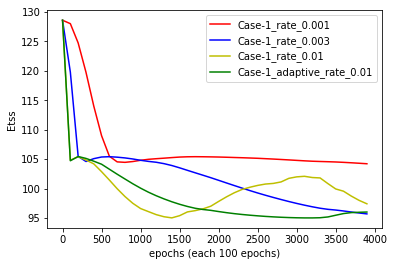

In [23]:
epochs = [i*100 for i in range(len(Etss_1b))]
plt.plot(epochs, Etss_1a,'r')
plt.plot(epochs, Etss_1b,'b')
plt.plot(epochs, Etss_1d,'y')
plt.plot(epochs, Etss_1c,'g')
plt.legend(["Case-1_rate_0.001","Case-1_rate_0.003","Case-1_rate_0.01","Case-1_adaptive_rate_0.01"])
plt.xlabel("epochs (each 100 epochs)")
plt.ylabel("Etss")

Text(0,0.5,'Etss')

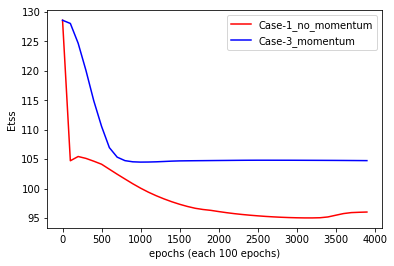

In [24]:
epochs = [i*100 for i in range(len(Etss_3a))]
plt.plot(epochs, Etss_1c[0:len(Etss_3a)],'r')
plt.plot(epochs, Etss_3a,'b')
plt.legend(["Case-1_no_momentum","Case-3_momentum"])
plt.xlabel("epochs (each 100 epochs)")
plt.ylabel("Etss")

Text(0,0.5,'Sensitivity')

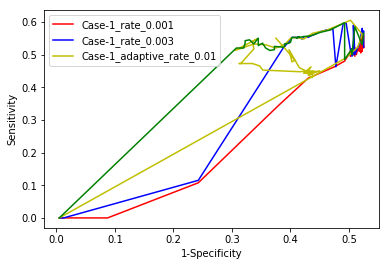

In [25]:
ind= np.argsort(specif_1a)
specif_1a = np.array(specif_1a)[ind]
sens_1a = np.array(sens_1a)[ind]


ind= np.argsort(specif_1b)
specif_1b = np.array(specif_1b)[ind]
sens_1b = np.array(sens_1b)[ind]

ind= np.argsort(specif_1c)
specif_1c = np.array(specif_1c)[ind]
sens_1c = np.array(sens_1c)[ind]

plt.plot(1-np.array(specif_1a), sens_1a,'r')
plt.plot(1-np.array(specif_1b), sens_1b,'b')
plt.plot(1-np.array(specif_1d), sens_1d,'y')
plt.plot(1-np.array(specif_1c), sens_1c,'g')
plt.legend(["Case-1_rate_0.001","Case-1_rate_0.003","Case-1_adaptive_rate_0.01"])
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")

Text(0,0.5,'Sensitivity')

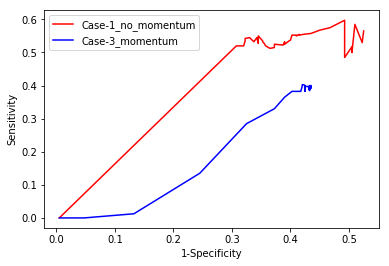

In [26]:

ind= np.argsort(specif_3a)
specif_3a = np.array(specif_3a)[ind]
sens_3a = np.array(sens_3a)[ind]

ind= np.argsort(specif_1c)
specif_1c = np.array(specif_1c)[ind]
sens_1c = np.array(sens_1c)[ind]


plt.plot(1-np.array(specif_1c), sens_1c,'r')
plt.plot(1-np.array(specif_3a), sens_3a,'b')
plt.legend(["Case-1_no_momentum","Case-3_momentum"])
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")